# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [2]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
#from dasquakesRainier import *
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel
import pytz
import os
import h5py
import numpy as np
import shutil
import matplotlib.dates as mdates 

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [4]:
events = search(starttime = datetime.datetime(2023, 8, 26, 0, 0), 
                endtime   = datetime.datetime(2023,8,30,0,0),
                #endtime   = datetime.datetime(2023,1,9,0,0),
                minmagnitude=0,
                maxmagnitude=4,
                maxradiuskm=20, 
                latitude=46.78579, 
                longitude=-121.73708)


print("Returned %s events" % len(events))

Returned 42 events


### Choose an event to analyze

In [5]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df


#event_df.iloc[0::]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
41,uw61945652,2023-08-29 10:21:44.840,"5 km ENE of Ashford, Washington",46.771833,-121.960667,10.03,0.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,2
40,uw61945622,2023-08-29 07:44:59.430,Washington,46.776500,-121.958333,9.50,0.88,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,12
39,uw61945612,2023-08-29 05:54:32.040,Washington,46.717333,-121.890500,4.52,0.81,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,10
38,uw61945607,2023-08-29 05:49:48.530,"5 km ENE of Ashford, Washington",46.775000,-121.962000,9.04,0.34,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,2
37,uw61945602,2023-08-29 05:25:49.600,"6 km ENE of Ashford, Washington",46.784833,-121.947833,9.24,0.60,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,6
36,uw61945592,2023-08-29 05:07:09.160,"23 km ENE of Ashford, Washington",46.849833,-121.756000,3.10,0.18,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,0
35,uw61945557,2023-08-29 03:07:57.930,"5 km ENE of Ashford, Washington",46.777667,-121.959667,9.93,0.33,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,2
34,uw61945447,2023-08-28 22:11:03.590,"7 km ENE of Ashford, Washington",46.783667,-121.941000,8.64,0.39,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,2
33,uw61954276,2023-08-28 21:51:59.670,"6 km ENE of Ashford, Washington",46.781667,-121.951667,9.23,1.17,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,21
32,uw61954221,2023-08-28 18:47:59.200,"5 km ENE of Ashford, Washington",46.775667,-121.961167,9.39,0.71,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,8


test, to see saved files

In [13]:


# Directory where the .h5 files will be saved
output_folder = '/data/fast0/eventsRainier'

# Iterate over each event in the DataFrame
for index, this_event in event_df.iterrows():
    this_id = this_event['id']
    
    # Filter the DataFrame to get the current event
    this_event_new = event_df[event_df.id == this_id]
    
    # Get the date and time of the current event without seconds
    t0 = this_event_new['time'].iloc[0].strftime("%Y-%m-%d_%H.%M.")
    
    # Build the filename prefix to search for
    file_prefix = f"decimator_{t0}"
    
    # Find files that start with the given prefix
    matching_files = [f for f in os.listdir(base_directory) if f.startswith(file_prefix) and f.endswith('.h5')]
    
    # Check if any matching files were found
    if matching_files:
        for file_name in matching_files:
            # Build the full path of the original file
            original_file_path = os.path.join(base_directory, file_name)
            
            # Open the original file
            with h5py.File(original_file_path, 'r') as f:
                # Get the dataset and attributes
                original_data = f['Acquisition/Raw[0]/RawData'][:, chan_min:chan_max]
                original_time = np.array(f['Acquisition/Raw[0]/RawDataTime'])
                attrs = dict(f['Acquisition'].attrs)
            
            # Build the full path of the new .h5 file
            new_file_path = os.path.join(output_folder, f"{this_id}.h5")
            
            # Save the data into a new .h5 file
            with h5py.File(new_file_path, 'w') as new_file:
                new_file.create_dataset('Acquisition/Raw[0]/RawData', data=original_data)
                new_file.create_dataset('Acquisition/Raw[0]/RawDataTime', data=original_time, dtype='f8')
                new_file['Acquisition'].attrs.update(attrs)
            
            print(f"File for event {this_id} has been saved to {new_file_path}")
    else:
        print(f"No corresponding files found for event {this_id}.")


File for event uw61945652 has been saved to /data/fast0/eventsRainier/uw61945652.h5
File for event uw61945622 has been saved to /data/fast0/eventsRainier/uw61945622.h5
File for event uw61945612 has been saved to /data/fast0/eventsRainier/uw61945612.h5
File for event uw61945607 has been saved to /data/fast0/eventsRainier/uw61945607.h5
File for event uw61945602 has been saved to /data/fast0/eventsRainier/uw61945602.h5
File for event uw61945592 has been saved to /data/fast0/eventsRainier/uw61945592.h5
File for event uw61945557 has been saved to /data/fast0/eventsRainier/uw61945557.h5
File for event uw61945447 has been saved to /data/fast0/eventsRainier/uw61945447.h5
File for event uw61954276 has been saved to /data/fast0/eventsRainier/uw61954276.h5
File for event uw61954221 has been saved to /data/fast0/eventsRainier/uw61954221.h5
File for event uw61954136 has been saved to /data/fast0/eventsRainier/uw61954136.h5
File for event uw61954116 has been saved to /data/fast0/eventsRainier/uw6195

# testing como quedaron 

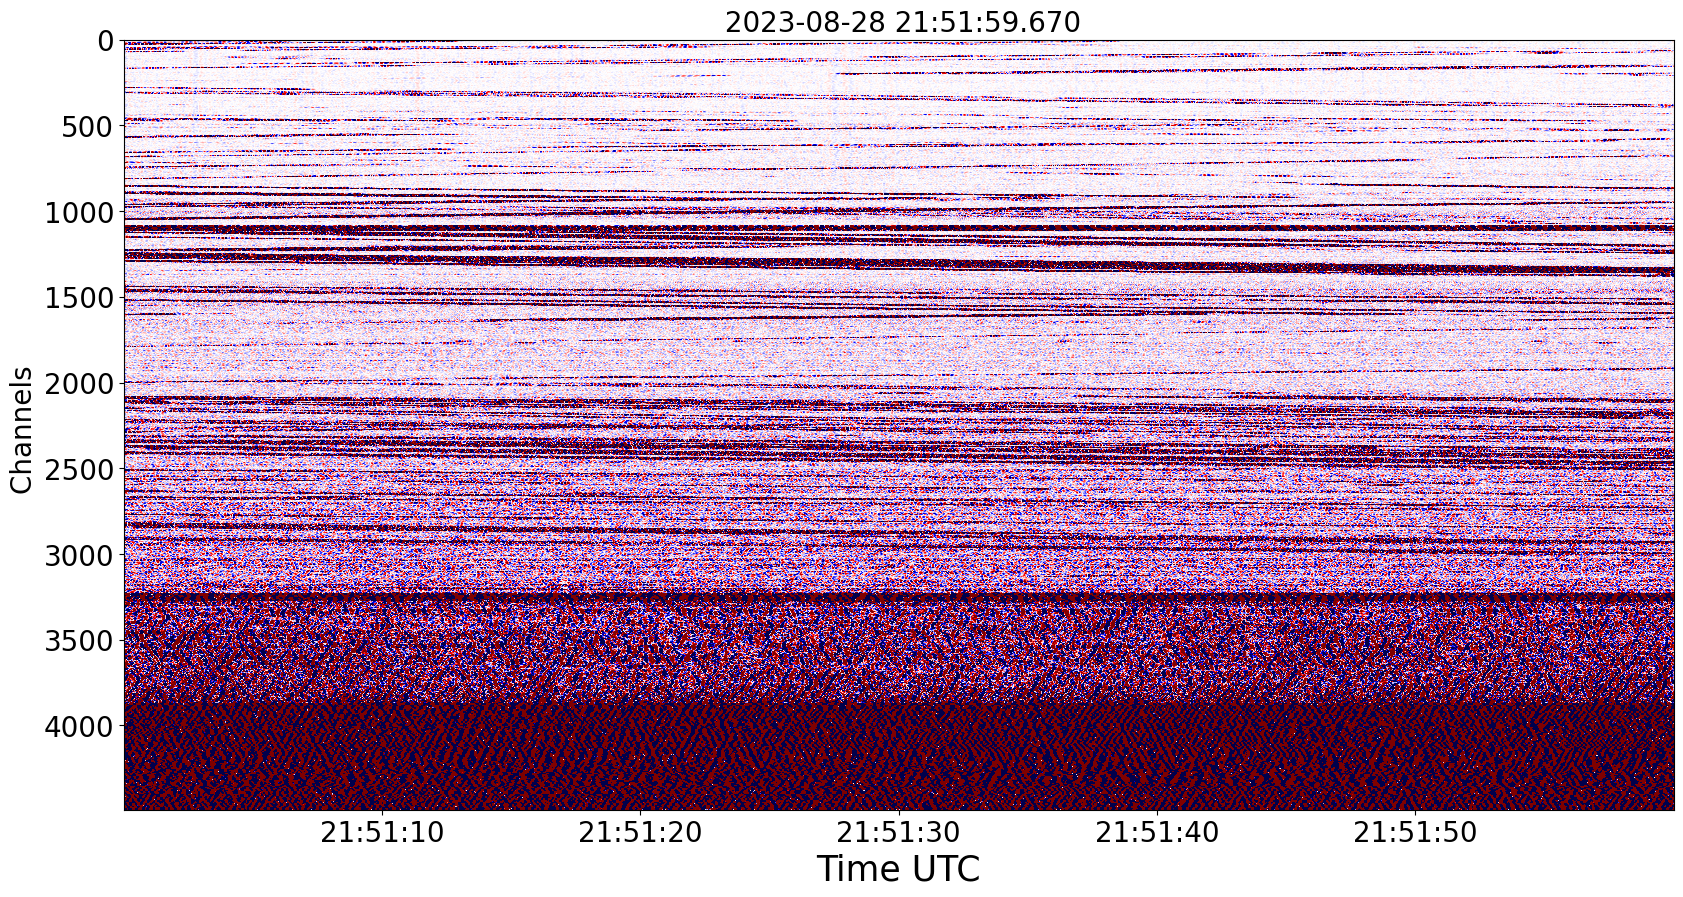

In [9]:
chan_min=0
chan_max=-1

#data_file = h5py.File('/data/data5/Converted/whidbey_2022-05-17_08-39-00_UTC_014654.h5','r')
data_file = h5py.File('/data/fast0/eventsRainier/uw61954276.h5','r')

this_data = np.array(data_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
this_time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
            
attrs=dict(data_file['Acquisition'].attrs)

data_file.close()
    

                        
channel_number = chan_max -chan_min
low_cut1 = 2
hi_cut1 = 9
fs=attrs['MaximumFrequency']*2
samples_per_file = 60*fs
b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
number_of_template = 1
 #filter

b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
data_filt = filtfilt(b,a,this_data,axis=0)
date_format = mdates.DateFormatter('%H:%M:%S')
x_lims = mdates.date2num(this_time)
x_max = data_filt.shape[1] * attrs['SpatialSamplingInterval']
dx = x_max / data_filt.shape[1]


fig,ax=plt.subplots(figsize=(20,10))
#plt.imshow(data_filt.T,cmap='seismic',aspect='auto',vmin=-0.8,vmax=0.8,extent=[x_lims[0],x_lims[-1],x_max,0])
plt.imshow(data_filt.T,cmap='seismic',aspect='auto',vmin=-0.05,vmax=0.05,extent=[x_lims[0],x_lims[-1],data_filt.shape[1],0])
plt.title(' 2023-08-28 21:51:59.670', fontsize=20)
plt.xlabel("Time UTC", fontsize=25)
plt.ylabel("Channels ", fontsize=20)
#plt.ylabel("Channels ", fontsize=25)

ax.xaxis.set_major_formatter(date_format)

ax.xaxis_date()
# Set font size for time and channel axis labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()